# Error analysis notebook (test data)

## Import packages

In [1]:
import pandas as pd
import math

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from elasticsearch import Elasticsearch

import warnings
import matplotlib
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
warnings.filterwarnings("ignore")

from enum import IntEnum

import json


/home/pilmus/thesis/venv37/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


## Set filepaths

In [6]:
gt = '../pre_processing/resources/training/2020/TREC-Fair-Ranking-training-sample.json'

erels_A = '../reranking/resources/relevances/Training_rel_scores_model_A.csv'
erels_B = '../reranking/resources/relevances/Training_rel_scores_model_B.csv'

doc_to_author = '../reranking/resources/mappings/doc_to_author.json'
doc_to_doc = '../reranking/resources/mappings/doc_to_author.json'

## Prepare dataframes

In [7]:
def eval_results_to_df(eval_result):
    df = pd.read_csv(eval_result, sep='\t', names=['key', 'qid', 'value'])
    df = df.pivot(index='qid', columns='key', values='value')
    df = df.reset_index()
    df = df.sort_values('difference')
    return df

In [8]:
# ground truth df
gtdf = pd.read_json(gt, lines=True).explode('documents')
gtdf['doc_id'] = gtdf.documents.apply(lambda row: row.get('doc_id'))
gtdf['doc_rel'] = gtdf.documents.apply(lambda row: row.get('relevance'))

# paired down relevances df
reldf = gtdf[['qid','query','doc_id','doc_rel']]

# est rel df
ereldf_A = pd.read_csv(erels_A)
ereldf_B = pd.read_csv(erels_B)

with open(doc_to_author) as f:
        dtam  = json.load(f)


## Extract information for specific query

Helper methods.

In [9]:
def extract_results_based_on_qid(qid, ranking_df):
    return ranking_df[ranking_df.qid == qid]

def extract_relevances_based_on_qid(qid, relevance_df):
    return relevance_df[relevance_df.qid == qid]

In [10]:
def count_relgrades(relevance_df):
    rel_counts = relevance_df.doc_rel.value_counts()
    rel_count = rel_counts[1]
    nonrel_count = rel_counts[0]
    return rel_count, nonrel_count

def count_relgrades_qid(qid, relevance):
    subrelevance = extract_relevances_based_on_qid(qid, relevance)
    return count_relgrades(subrelevance)


## Methods

In [11]:
def plot_rel_nonrel_per_rank(data):
    """Plot the number of times a (non)relevant item appeared at a rank."""
    
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.barplot(x="rank", y="count", hue="relkind", data=data)

In [12]:
def plots_for_qid(qid,ranking,relevance,k=2):
    plot_rel_nonrel_per_rank_per_relkind_for_qid(qid, ranking, relevance, regline=False)
    plot_rel_nonrel_per_rank_per_relkind_for_qid(qid, ranking, relevance, regline=True)

    plot_doc_occurrence_per_rank_for_qid(qid, ranking, relevance,k)
    plot_doc_occurrence_per_rank_for_qid(qid, ranking, relevance,k,rev=True)
    plot_doc_pos_count_for_qid(qid, ranking, relevance)

### Methods count per rank

In [13]:
def count_rel_nonrel_per_rank(rankings_df, relevance_df):
    """rankings_df and relevance_df should already be reduced to the information for a single qid"""
    countdict = {k :{'r':0,'nr':0} for k in range(1,len(rankings_df['ranking'].iloc[0]) + 1)}
    for idx, row in rankings_df.iterrows():
        for i, doc in enumerate(row['ranking']):
            rel = relevance_df[relevance_df.doc_id == doc].doc_rel.iloc[0]
            if rel == 0:
                countdict[i+1]['nr'] = countdict[i+1]['nr'] + 1
            elif rel == 1:
                countdict[i+1]['r'] = countdict[i+1]['r'] + 1
            else:
                raise ValueError
    return countdict
            

In [14]:
def rel_nonrel_per_rank_counts_to_sns_df(countdict):
    unpacked = [record for reclist in [[{**{'rank':k},**{'relkind':k2,'count':v2}} for k2,v2 in v.items()] for k,v in countdict.items()] for record in reclist]
    return pd.DataFrame(unpacked)

In [15]:
def plot_rel_nonrel_per_rank_per_relkind(data,num_rel,regline=False):
    """Plot the number of times a (non)relevant item appeared at a rank, split by rank."""
    
    pi = iter(sns.color_palette())
    pi2 = iter(sns.color_palette('dark'))
    f = next(pi)
    f2 = next(pi2)
    s = next(pi)
    s2 = next(pi2)
    next(pi)
    next(pi2)
    t = next(pi)
    t2 = next(pi2)

    fig, ax = plt.subplots(1,2,figsize = (17.7,8.27))
    ax[0].title.set_text('Relevant item counts')
    ax[1].title.set_text('Nonrelevant item counts')

    colorsf = [f] * num_rel + [f2] * (len(data) - num_rel)
    colorss = [s] * num_rel + [s2] * (len(data) - num_rel)
    
    sns.barplot(x="rank", y="count", data=data[data.relkind=='r'],ax=ax[0],palette=sns.color_palette(colorsf))
    sns.barplot(x="rank", y="count", data=data[data.relkind=='nr'],ax=ax[1],palette=sns.color_palette(colorss))

    if regline:
        colorst = [t] * num_rel + [t2] * (len(data) - num_rel)
        sns.regplot(x="rank", y="count", data=data[data.relkind=='r'],ax=ax[0], scatter_kws={"s": 0}, palette=sns.color_palette(colorst))
        sns.regplot(x="rank", y="count", data=data[data.relkind=='nr'],ax=ax[1], scatter_kws={"s": 0},palette=sns.color_palette(colorst))
    return fig


In [16]:
def plot_rel_nonrel_per_rank_per_relkind_for_qid(qid, ranking, relevance, regline=False):
    subranking = extract_results_based_on_qid(qid, ranking)
    subrelevance = extract_relevances_based_on_qid(qid, relevance)
    
    num_rel_docs, num_nonrel_docs = count_relgrades(subrelevance)
    
    rel_nonrel_counts = count_rel_nonrel_per_rank(subranking, subrelevance)
    rel_nonrel_df = rel_nonrel_per_rank_counts_to_sns_df(rel_nonrel_counts)
    fig = plot_rel_nonrel_per_rank_per_relkind(rel_nonrel_df,num_rel_docs,regline=regline)
    fig.suptitle(f"(Non-)relevant documents per rank for {qid}, top={num_rel_docs}")
    

### Methods doc occurrence in top positions

In [17]:
def count_doc_occurrence_per_rank(rankings_df):
    """Count how often each document occurs at each rank."""
    count_per_doc_per_rank = {i: {} for i in list(range(1,len(rankings_df['ranking'].iloc[0]) + 1))}

    for idx, row in rankings_df.iterrows():
        for j, doc in enumerate(row['ranking']):
            i = j + 1
            if not doc in count_per_doc_per_rank[i]:
                count_per_doc_per_rank[i][doc] = 0
            count_per_doc_per_rank[i][doc] = count_per_doc_per_rank[i][doc] + 1
    return count_per_doc_per_rank

In [18]:
def doc_occurrence_per_rank_to_sns_df(occurrence_dict, relevance_df):
    unpacked = [d for dlist in [[{'rank':k, 'doc_id':k2, 'count':v2} for k2, v2 in v.items()] for k,v in occurrence_dict.items()] for d in dlist]
    unpacked_df = pd.DataFrame(unpacked)

    return pd.merge(unpacked_df,reldf[['doc_id','doc_rel']],on='doc_id',how='left')

In [19]:
def plot_doc_occurrence_per_rank(data, k=2, rev=False):
    """Show how often each document in :data: appears at each rank <= k."""
    sns.set_palette("tab10")
    pi = iter(sns.color_palette())
    first = next(pi)
    second = next(pi)
    
    data["doc_labels"] = data.doc_id.apply(lambda row: f"{row[:4]}...")
    
    fig, ax = plt.subplots(1, k, figsize = (9*k, 8))
    
    for i in range(0,k):
        rank = i + 1
        if rev:
            rank = len(set(data["rank"].to_list())) - rank
    
        thisaxdata = data[data['rank'] == rank].sort_values(by='count',ascending=False)
    
        clrs = [first if rel == 1 else second for rel in thisaxdata.doc_rel.to_list()]
        sns.barplot(x="doc_labels", y="count",palette=clrs, data=thisaxdata,ax=ax[i])
        ax[i].title.set_text(f'Rank {rank}')
        _ = ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation = -70)
        ax[i].legend(labels=["rel","nonrel"], title='relkind')
        leg = ax[i].get_legend()
        leg.legendHandles[0].set_color(first)
        leg.legendHandles[1].set_color(second)
    return fig

In [20]:
def plot_doc_occurrence_per_rank_for_qid(qid, ranking, relevance, k=2, rev=False):
    subranking = extract_results_based_on_qid(qid, ranking)
    subrelevance = extract_relevances_based_on_qid(qid, relevance)

    doc_per_rank_counts = count_doc_occurrence_per_rank(subranking)
    rank_occurrence_df = doc_occurrence_per_rank_to_sns_df(doc_per_rank_counts, subrelevance)

    fig = plot_doc_occurrence_per_rank(rank_occurrence_df, k, rev)
    fig.suptitle(f"Document counts per rank for {qid}")
    
    

### Methods number of times a doc is in a top position

In [21]:
def count_pos_of_documents(ranking_df, num_relevant_docs):
    doc_pos_count_dict = {}

    for idx, row in ranking_df.iterrows():
        for i, doc in enumerate(row['ranking']):
            if not doc in doc_pos_count_dict:
                doc_pos_count_dict[doc] = {"top": 0, "bot": 0}
            if i < num_relevant_docs:
                doc_pos_count_dict[doc]["top"] = doc_pos_count_dict[doc]["top"] + 1
            else:
                doc_pos_count_dict[doc]["bot"] = doc_pos_count_dict[doc]["bot"] + 1

    return doc_pos_count_dict        

In [22]:
def document_pos_count_to_sns_df(doc_pos_count_dict, relevance_df):
    unpacked = [d for dlist in [[{'doc_id':k, 'pos':k2, 'count':v2} for k2, v2 in v.items()] for k,v in doc_pos_count_dict.items()] for d in dlist]
    unpacked_df = pd.DataFrame(unpacked)
    
    m = pd.merge(unpacked_df,relevance_df[['doc_id','doc_rel']],on='doc_id',how='left')
    return m.drop_duplicates()

In [23]:
def document_pos_count_df_for_qid(qid,ranking,relevance):
    subranking = extract_results_based_on_qid(qid, ranking)
    subrelevance = extract_relevances_based_on_qid(qid,relevance)
    num_rel_docs, num_nonrel_docs = count_relgrades(subrelevance)

    
    doc_position_counts = count_pos_of_documents(subranking, num_rel_docs)
    doc_pos_count_df = document_pos_count_to_sns_df(doc_position_counts, subrelevance)
    return doc_pos_count_df
    

In [24]:
def plot_doc_pos_count(data,numrel,numnrel,sortby=['count'],no_author_ids=None):
    """Plot how many times each document occurred in the top and bottom positions."""
    
    
    sns.set_palette("tab10")
    pi = iter(sns.color_palette())
    first = next(pi)
    second = next(pi)

    data["doc_labels"] = data.doc_id.apply(lambda row: f"{row[:4]}...")


    fig, ax = plt.subplots(1, 2, figsize = (18, 8))
    _ = ax[0].title.set_text(f'Occurrence of doc in top pos (k={numrel})')
    _ = ax[1].title.set_text(f'Occurrence of doc in bottom pos (k={numnrel})')

    for i, pos in enumerate(["top","bot"]):
        _ = ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation = -70)
        thisaxdata = data[data['pos'] == pos].sort_values(by=sortby,ascending=False)
        
     
        
        clrs = [first if rel == 1 else second for rel in thisaxdata.doc_rel.to_list()]
        
        sns.barplot(x="doc_labels", y="count",palette=clrs, data=thisaxdata,ax=ax[i])
        
        if no_author_ids:
            thisaxdata['secondcount'] = thisaxdata.apply(lambda row: row['count'] if row['doc_id'] in no_author_ids else 0, axis=1)
            sns.barplot(x="doc_labels", y="secondcount",palette=clrs, data=thisaxdata,ax=ax[i],hatch='//')
            ax[i].set_ylabel('count')
     
        ax[i].legend(labels=["rel","nonrel"], title='relkind')
        
        leg = ax[i].get_legend()
        leg.legendHandles[0].set_color(first)
        leg.legendHandles[1].set_color(second)
        
  
    return fig


In [25]:
def plot_doc_pos_count_for_qid(qid, ranking, relevance,sortby=['count'], no_author_ids=None):
    doc_pos_count_df = document_pos_count_df_for_qid(qid,ranking,relevance)
    subrelevance = extract_relevances_based_on_qid(qid,relevance)
    num_rel_docs, num_nonrel_docs = count_relgrades(subrelevance)
    fig = plot_doc_pos_count(doc_pos_count_df,num_rel_docs,num_nonrel_docs,sortby=sortby,no_author_ids=no_author_ids)

    fig.suptitle(f"Document position counts {qid}")

## Visualization

For each rank, we show how often it is occupied by a relevant document. We show this for the top and bottom 10 queries so we can determine both what documents are placed in top positions on easy queries and which on difficult queries.

In [26]:
noauth_docids = list(filter( lambda x: dtam [x] == [],dtam .keys()))

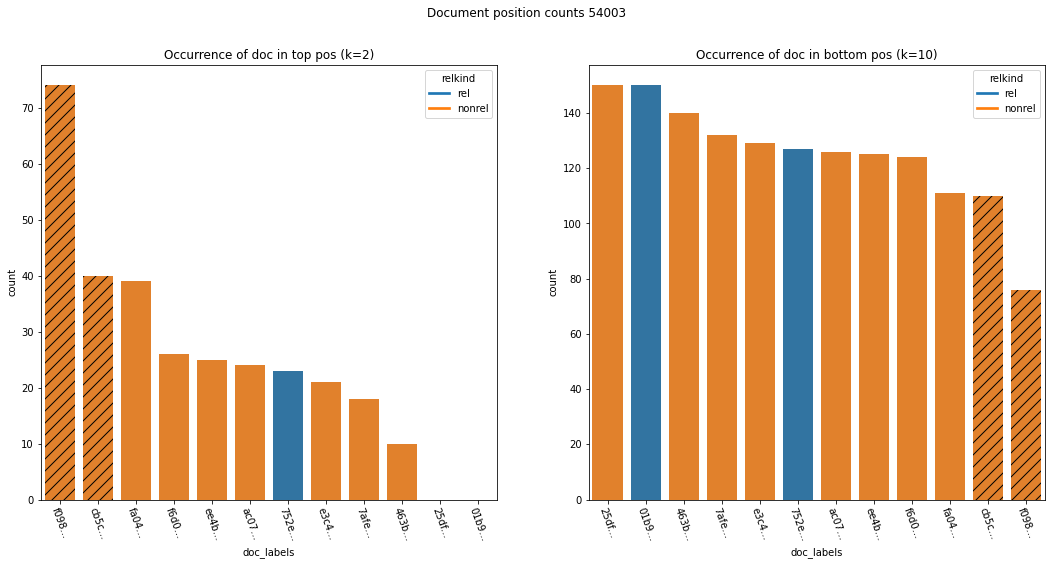

In [39]:
# ranking df
ranking = '../evaluation/resources/2020/jsonruns/ac_controller_train10_meta_9_min_author_none_train.json'
eval_result = '../evaluation/resources/2020/eval_results/ac_controller_train10_meta_9_min_author_none_train_TREC-Fair-Ranking-training-sample_-10-full-annotations-DocHLevel-mixed_group-qrels_EEL.tsv'


rdf = pd.read_json(ranking, lines=True)
# eval result dfs
edf = eval_results_to_df(eval_result)
for i, q in enumerate(edf.sort_values(by='difference').qid.to_list()):
    plot_doc_pos_count_for_qid(54003,rdf,reldf,sortby=['count'], no_author_ids=noauth_docids)
    if i == 0: 
        break

In [40]:
edf.sort_values(by='difference')

key,qid,difference,disparity,relevance
0,3462,0.089096,1.713695,1.368985
8,27887,0.100727,1.315350,0.959420
16,66637,0.114201,2.844080,2.291052
14,54003,0.164267,3.088244,2.390120
19,120668,0.164368,1.269984,1.112479
4,12096,0.265953,1.353489,1.410046
15,64062,0.267247,2.208494,1.528353
5,12828,0.277408,1.699193,1.175036
3,12073,0.296184,1.198167,0.781570
12,49766,0.315216,0.869996,0.597279


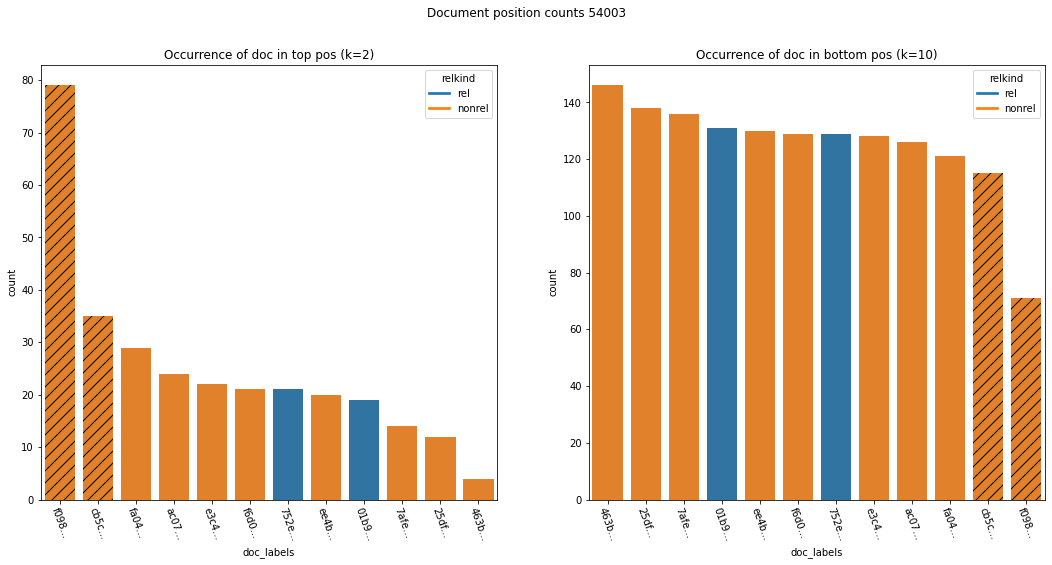

In [41]:
# ranking df
ranking = '../evaluation/resources/2020/jsonruns/ac_controller_train10_meta_9_max_author_none_train.json'
eval_result = '../evaluation/resources/2020/eval_results/ac_controller_train10_meta_9_max_author_none_train_TREC-Fair-Ranking-training-sample_-10-full-annotations-DocHLevel-mixed_group-qrels_EEL.tsv'
rdf = pd.read_json(ranking, lines=True)
edf = eval_results_to_df(eval_result)

for i, q in enumerate(edf.sort_values(by='difference').qid.to_list()):
    plot_doc_pos_count_for_qid(54003,rdf,reldf,sortby=['count'], no_author_ids=noauth_docids)
    if i == 0: 
        break


In [42]:
edf.sort_values(by='difference')

key,qid,difference,disparity,relevance
2,10795,0.083682,1.495963,1.310841
8,27887,0.092150,1.290345,0.951206
4,12096,0.094068,1.883897,1.761192
0,3462,0.095052,1.768770,1.393544
16,66637,0.131333,2.958529,2.339710
5,12828,0.132550,1.501716,1.148727
12,49766,0.147025,0.773705,0.633229
14,54003,0.151772,3.027052,2.365771
3,12073,0.188847,1.147785,0.810047
17,67404,0.230946,1.618686,1.547214


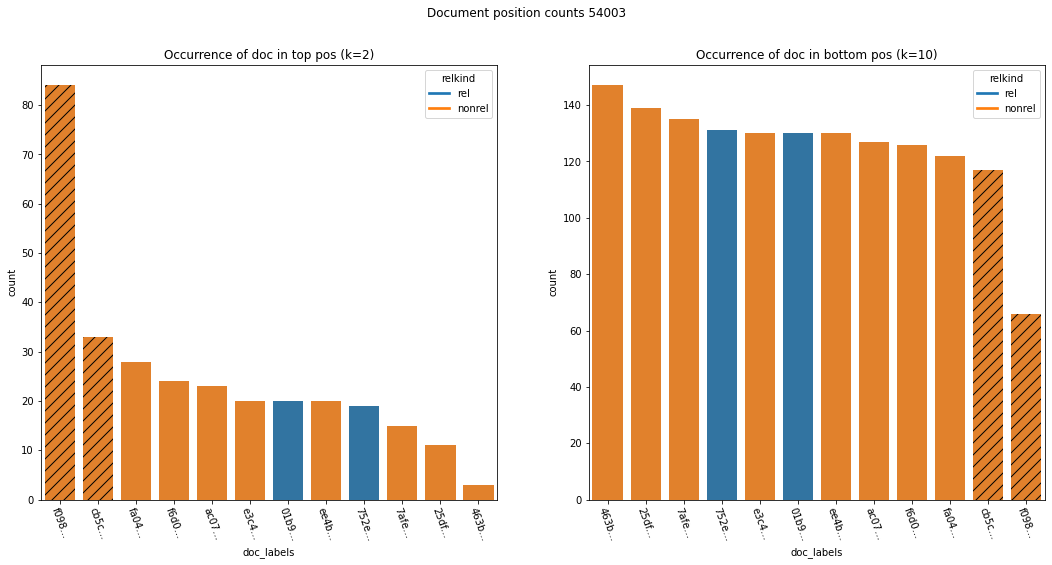

In [43]:
# ranking df
ranking = '../evaluation/resources/2020/jsonruns/ac_controller_train10_meta_9_linear_author_none_train.json'
eval_result = '../evaluation/resources/2020/eval_results/ac_controller_train10_meta_9_linear_author_none_train_TREC-Fair-Ranking-training-sample_-10-full-annotations-DocHLevel-mixed_group-qrels_EEL.tsv'
rdf = pd.read_json(ranking, lines=True)
edf = eval_results_to_df(eval_result)

for i, q in enumerate(edf.sort_values(by='difference').qid.to_list()):
    plot_doc_pos_count_for_qid(54003,rdf,reldf,sortby=['count'], no_author_ids=noauth_docids)
    if i == 0: 
        break


In [44]:
edf.sort_values(by='difference')

key,qid,difference,disparity,relevance
0,3462,0.086649,1.672805,1.349763
8,27887,0.095488,1.301946,0.955337
16,66637,0.114425,2.843926,2.290863
2,10795,0.133299,1.995261,1.535681
5,12828,0.133960,1.511845,1.153086
14,54003,0.154095,3.039261,2.370714
19,120668,0.165827,1.273093,1.113304
3,12073,0.188847,1.147785,0.810047
15,64062,0.270318,2.216094,1.530618
4,12096,0.277303,1.340470,1.397862


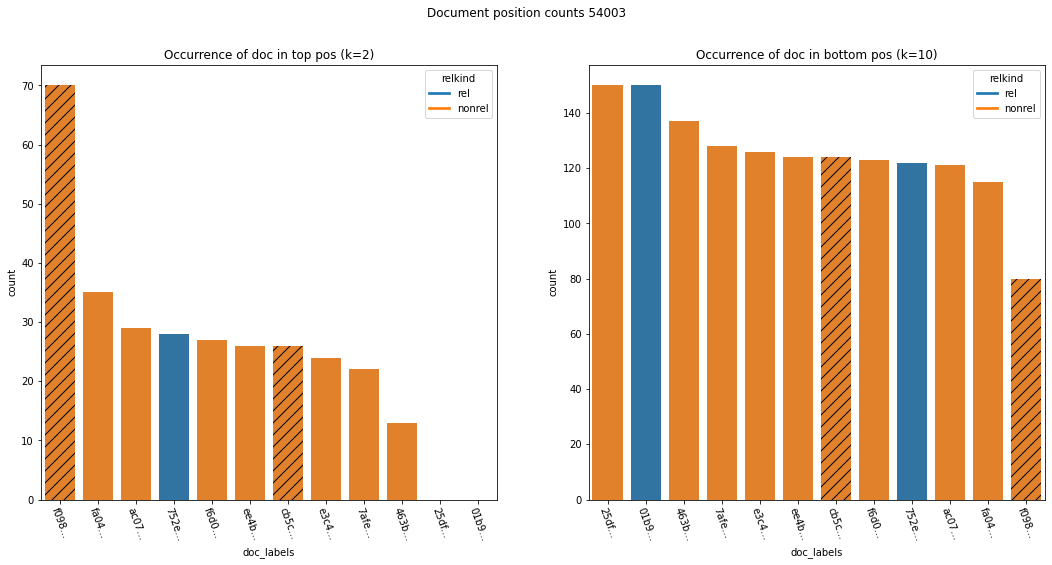

In [45]:
# ranking df
ranking = '../evaluation/resources/2020/jsonruns/ac_controller_train10_meta_99_min_author_none_train.json'
eval_result = '../evaluation/resources/2020/eval_results/ac_controller_train10_meta_99_min_author_none_train_TREC-Fair-Ranking-training-sample_-10-full-annotations-DocHLevel-mixed_group-qrels_EEL.tsv'


rdf = pd.read_json(ranking, lines=True)
# eval result dfs
edf = eval_results_to_df(eval_result)
for i, q in enumerate(edf.sort_values(by='difference').qid.to_list()):
    plot_doc_pos_count_for_qid(54003,rdf,reldf,sortby=['count'], no_author_ids=noauth_docids)
    if i == 0: 
        break

In [46]:
edf.sort_values(by='difference')

key,qid,difference,disparity,relevance
0,3462,0.078529,1.662932,1.348887
16,66637,0.119513,2.881148,2.306930
19,120668,0.136455,1.359089,1.170987
14,54003,0.146741,2.982344,2.345933
3,12073,0.175294,0.988372,0.737118
8,27887,0.183289,1.517883,1.019405
2,10795,0.247611,2.368093,1.664941
5,12828,0.272957,1.664973,1.160152
15,64062,0.284631,2.267841,1.549334
12,49766,0.285063,0.856614,0.605664


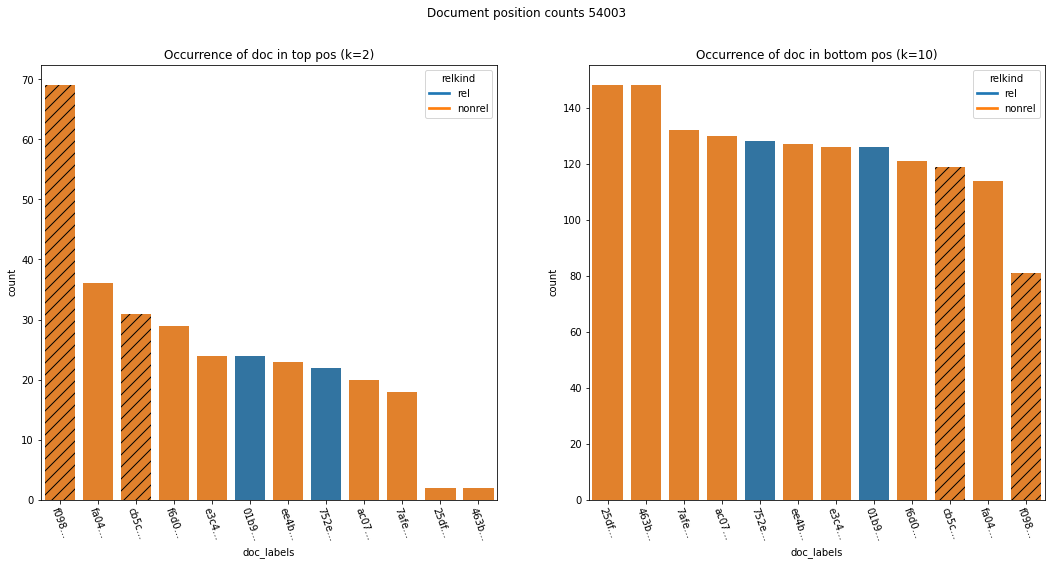

In [47]:
# ranking df
ranking = '../evaluation/resources/2020/jsonruns/ac_controller_train10_meta_99_max_author_none_train.json'
eval_result = '../evaluation/resources/2020/eval_results/ac_controller_train10_meta_99_max_author_none_train_TREC-Fair-Ranking-training-sample_-10-full-annotations-DocHLevel-mixed_group-qrels_EEL.tsv'
rdf = pd.read_json(ranking, lines=True)
edf = eval_results_to_df(eval_result)

for i, q in enumerate(edf.sort_values(by='difference').qid.to_list()):
    plot_doc_pos_count_for_qid(54003,rdf,reldf,sortby=['count'], no_author_ids=noauth_docids)
    if i == 0: 
        break


In [48]:
edf.sort_values(by='difference')

key,qid,difference,disparity,relevance
5,12828,0.086219,1.417510,1.129789
0,3462,0.091515,1.730205,1.376030
8,27887,0.100061,1.317605,0.960880
2,10795,0.111410,1.776957,1.437474
3,12073,0.122343,1.100023,0.819419
16,66637,0.125686,2.923262,2.324901
14,54003,0.138569,2.957457,2.337575
19,120668,0.160859,1.282005,1.120243
12,49766,0.201922,0.789986,0.613920
13,51432,0.210464,1.024330,0.656936


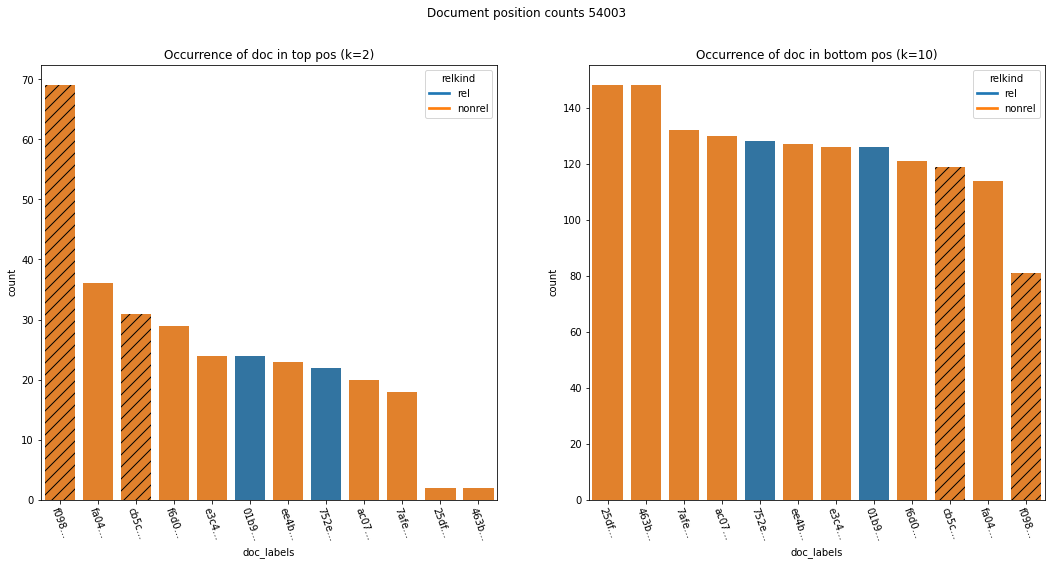

In [49]:
# ranking df
ranking = '../evaluation/resources/2020/jsonruns/ac_controller_train10_meta_99_linear_author_none_train.json'
eval_result = '../evaluation/resources/2020/eval_results/ac_controller_train10_meta_99_linear_author_none_train_TREC-Fair-Ranking-training-sample_-10-full-annotations-DocHLevel-mixed_group-qrels_EEL.tsv'
rdf = pd.read_json(ranking, lines=True)
edf = eval_results_to_df(eval_result)

for i, q in enumerate(edf.sort_values(by='difference').qid.to_list()):
    plot_doc_pos_count_for_qid(54003,rdf,reldf,sortby=['count'], no_author_ids=noauth_docids)
    if i == 0: 
        break


In [50]:
edf.sort_values(by='difference')

key,qid,difference,disparity,relevance
5,12828,0.086219,1.417510,1.129789
0,3462,0.091515,1.730205,1.376030
8,27887,0.100061,1.317605,0.960880
2,10795,0.111410,1.776957,1.437474
16,66637,0.115068,2.852495,2.294826
3,12073,0.122343,1.100023,0.819419
14,54003,0.138569,2.957457,2.337575
19,120668,0.160859,1.282005,1.120243
13,51432,0.210464,1.024330,0.656936
15,64062,0.275454,2.219541,1.529773


# sep

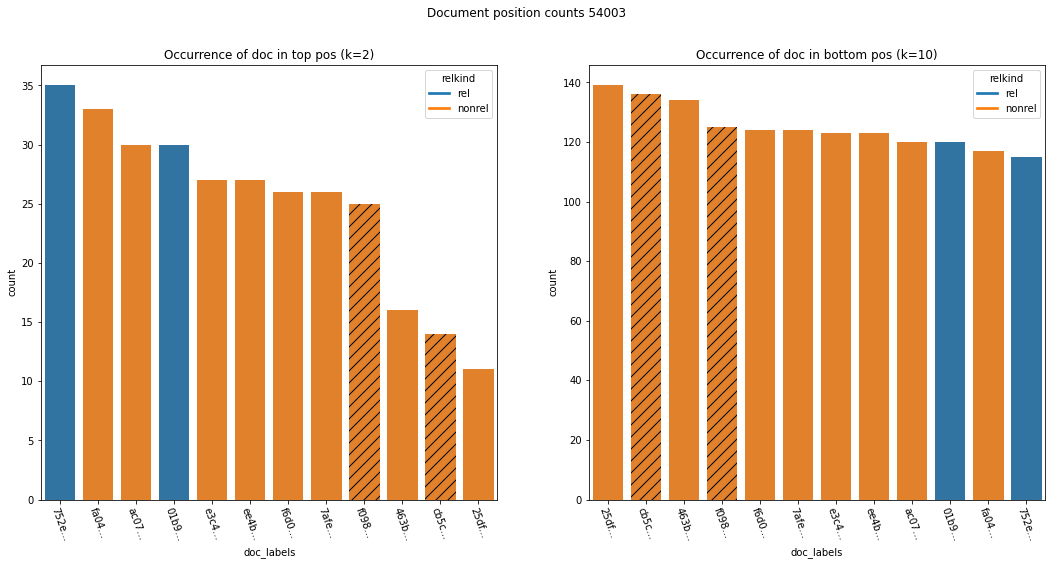

In [59]:
# ranking df
ranking = '../evaluation/resources/2020/jsonruns/ac_controller_train10_meta_9_linear_author_one_train.json'
eval_result = '../evaluation/resources/2020/eval_results/ac_controller_train10_meta_9_linear_author_none_train_TREC-Fair-Ranking-training-sample_-10-full-annotations-DocHLevel-mixed_group-qrels_EEL.tsv'


rdf = pd.read_json(ranking, lines=True)
# eval result dfs
edf = eval_results_to_df(eval_result)
for i, q in enumerate(edf.sort_values(by='difference').qid.to_list()):
    plot_doc_pos_count_for_qid(54003,rdf,reldf,sortby=['count'], no_author_ids=noauth_docids)
    if i == 0: 
        break

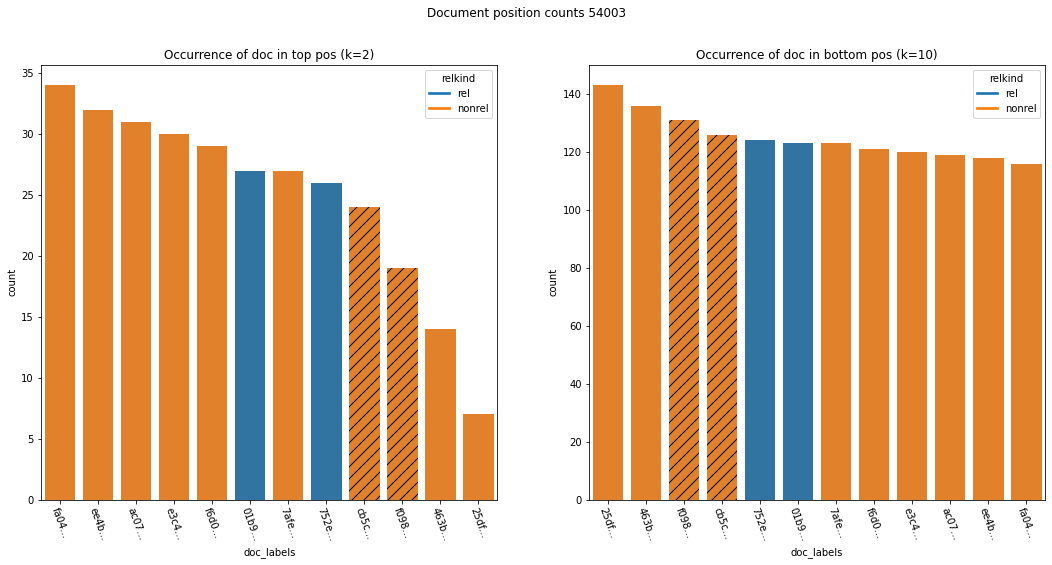

In [60]:
# ranking df
ranking = '../evaluation/resources/2020/jsonruns/ac_controller_train10_meta_9_linear_author_ind_train.json'
eval_result = '../evaluation/resources/2020/eval_results/ac_controller_train10_meta_9_linear_author_ind_train_TREC-Fair-Ranking-training-sample_-10-full-annotations-DocHLevel-mixed_group-qrels_EEL.tsv'
rdf = pd.read_json(ranking, lines=True)
edf = eval_results_to_df(eval_result)

for i, q in enumerate(edf.sort_values(by='difference').qid.to_list()):
    plot_doc_pos_count_for_qid(54003,rdf,reldf,sortby=['count'], no_author_ids=noauth_docids)
    if i == 0: 
        break


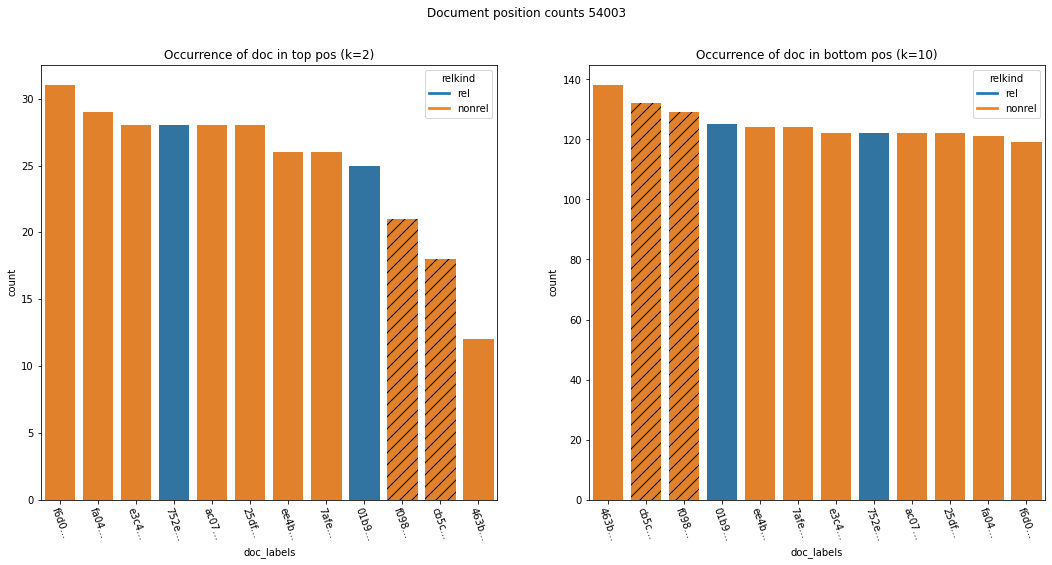

In [61]:
# ranking df
ranking = '../evaluation/resources/2020/jsonruns/ac_controller_train10_meta_9_linear_doc_train.json'
eval_result = '../evaluation/resources/2020/eval_results/ac_controller_train10_meta_9_linear_doc_train_TREC-Fair-Ranking-training-sample_-10-full-annotations-DocHLevel-mixed_group-qrels_EEL.tsv'
rdf = pd.read_json(ranking, lines=True)
edf = eval_results_to_df(eval_result)

for i, q in enumerate(edf.sort_values(by='difference').qid.to_list()):
    plot_doc_pos_count_for_qid(54003,rdf,reldf,sortby=['count'], no_author_ids=noauth_docids)
    if i == 0: 
        break
